In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import os

D:\Anaconda\lib\site-packages\pandas\core\arrays\masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# Channel means RGB colours

BatchSize = 32
ImageSize = 256
Channel = 3    
Epochs = 5

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Data PlantVillage",
    batch_size = BatchSize,
    image_size = (ImageSize, ImageSize),
    shuffle = True
)

Found 2152 files belonging to 3 classes.


In [4]:
len(dataset)

68

In [5]:
ClassNames = dataset.class_names  
ClassNames

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [112]:
#Label initially is a tensor object. So we convert it in a numpy list.
# print(label)
# print(label.numpy())

for image,label in dataset.take(1):
    print(image.shape)
    print(image[0].shape)
    print(label[0])
    print(label[0].numpy())

(32, 256, 256, 3)
(256, 256, 3)
tf.Tensor(1, shape=(), dtype=int32)
1


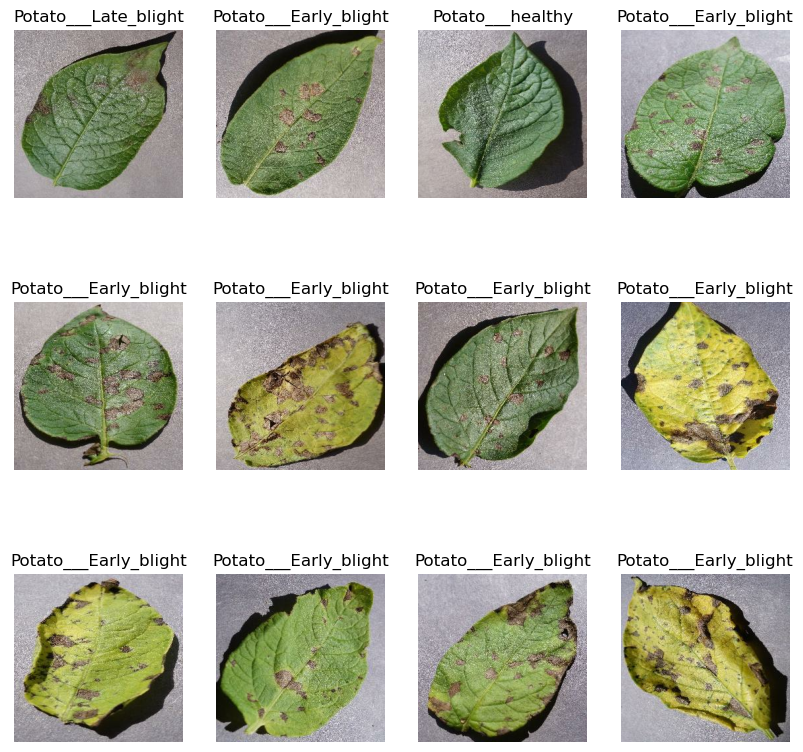

In [144]:
plt.figure(figsize=(10,10))

for image,label in dataset.take(1):

    for i in range(12):
        ax = plt.subplot(3,4,i+1)
    
        plt.imshow(image[i].numpy().astype('int'))
        plt.title(ClassNames[label[i]])
        plt.axis('off')

### 80% Training 20% Testing 
#### 10% Validation 10% Test

In [7]:
train_size = 0.8
n1 = int(len(dataset)*train_size)

train_df = dataset.take(n1)
print(len(train_df))

testing_df = dataset.skip(n1)
print(len(testing_df))

54
14


In [8]:
validation_size = 0.1
n2 = round(len(dataset)*validation_size)

val_df = testing_df.take(n2)
test_df = testing_df.skip(n2)

print(len(val_df))
print(len(test_df))

7
7


In [9]:
def get_partition(df, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000  ):
    
    if shuffle:
        df = df.shuffle(shuffle_size, seed=12)
        
    n1 = round(len(df)*train_split)
    train_df = df.take(n1)
    testing_df = df.skip(n1)

    n2 = round(len(df)*val_split)
    val_df = testing_df.take(n2)
    test_df = testing_df.skip(n2)
    
    return train_df, val_df, test_df

In [10]:
train_df, val_df, test_df = get_partition(dataset)

In [11]:
print(len(train_df))
print(len(val_df))
print(len(test_df))

54
7
7


In [13]:
### "Cache" saves images in the most recent memory. 
### When 1 batch is called and processed "Prefetch" loads next batch beforehand for further processing

train_df = train_df.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_df = val_df.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_df = test_df.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

## Model Building

In [14]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(ImageSize, ImageSize),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [15]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [17]:
InputShape = (BatchSize, ImageSize, ImageSize, Channel)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=InputShape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape = InputShape)

In [18]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [19]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

In [23]:
history = model.fit(
    train_df,
    batch_size = BatchSize,
    validation_data = val_df,
    verbose = 1,
    epochs = 5
)

Epoch 1/5
54/54 [==============================] - 213s 4s/step - loss: 0.8780 - accuracy: 0.5110 - val_loss: 0.8431 - val_accuracy: 0.5268
Epoch 2/5
54/54 [==============================] - 190s 4s/step - loss: 0.6810 - accuracy: 0.6788 - val_loss: 0.5156 - val_accuracy: 0.7455
Epoch 3/5
54/54 [==============================] - 165s 3s/step - loss: 0.3898 - accuracy: 0.8356 - val_loss: 0.2835 - val_accuracy: 0.8973
Epoch 4/5
54/54 [==============================] - 167s 3s/step - loss: 0.2903 - accuracy: 0.8808 - val_loss: 0.2473 - val_accuracy: 0.9018
Epoch 5/5
54/54 [==============================] - 170s 3s/step - loss: 0.2359 - accuracy: 0.8993 - val_loss: 0.1489 - val_accuracy: 0.9375


In [26]:
scores = model.evaluate(test_df)
scores

7/7 [==============================] - 7s 907ms/step - loss: 0.1670 - accuracy: 0.9375


[0.1669887751340866, 0.9375]

In [27]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [28]:
type(history.history['loss'])

len(history.history['loss'])

history.history['loss'][:5]    # show loss for first 5 epochs

[0.8780234456062317,
 0.6809888482093811,
 0.3898050785064697,
 0.29027891159057617,
 0.23590858280658722]

# Visualization

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

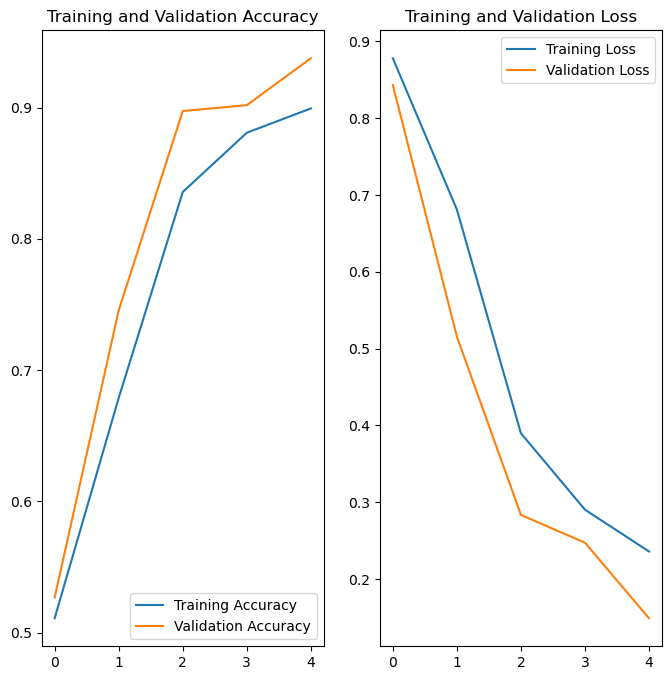

In [37]:
plt.figure(figsize=(8, 8))

plt.subplot(1, 2, 1)
plt.plot(range(Epochs), acc, label='Training Accuracy')
plt.plot(range(Epochs), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(Epochs), loss, label='Training Loss')
plt.plot(range(Epochs), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

First Image to Predict
Original Label:  Potato___Late_blight
1/1 [==============================] - 0s 420ms/step
Predicted Label : Potato___Late_blight


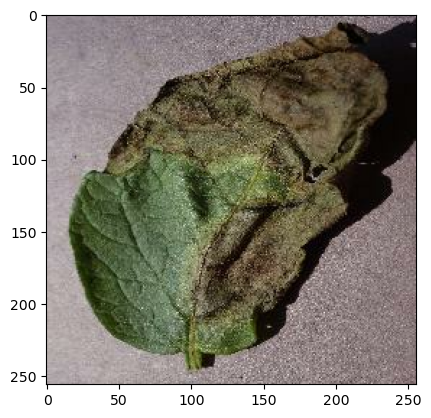

In [68]:
for image, label in test_df.take(1):
    first_image = image[0].numpy().astype('int')
    first_label = label[0].numpy()
    
    print('First Image to Predict')
    plt.imshow(first_image)
    print('Original Label: ', ClassNames[first_label])
    
    batch_prediction = model.predict(image)
    print('Predicted Label :', ClassNames[np.argmax(batch_prediction[0])])
    

In [135]:
def predict(model, img):
    image = img.numpy()
    image = tf.expand_dims(image, 0)
    
    prediction = model.predict(image)
    predicted_class = ClassNames[np.argmax(prediction)]
    confidence = round(100 * (np.max(prediction[0])), 2)
    
    return predicted_class, confidence




# def predict(model, img):
#     img_array = tf.keras.preprocessing.image.img_to_array(img.numpy())
#     img_array = tf.expand_dims(img_array, 0)

#     predictions = model.predict(img_array)
#     predicted_class = ClassNames[np.argmax(predictions[0])]
#     confidence = round(100 * (np.max(predictions[0])), 2)
    
#     return predicted_class, confidence

1/1 [==============================] - 0s 101ms/step


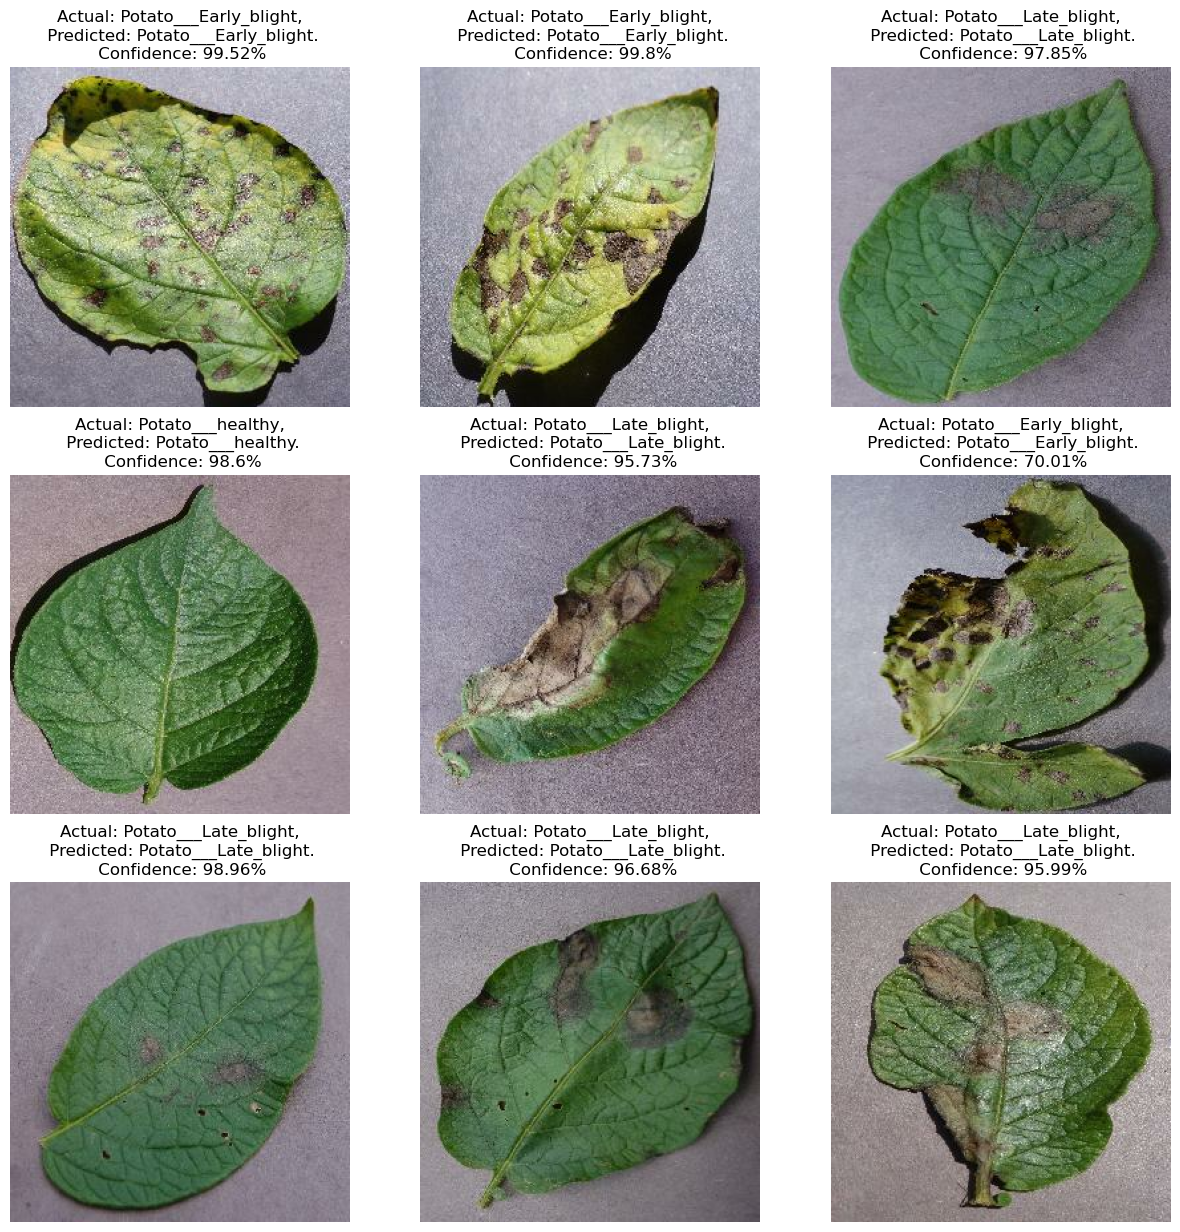

In [136]:
plt.figure(figsize=(15, 15))

for images, labels in test_df.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("int"))
        
        predicted_class, confidence = predict(model, images[i])
        actual_class = ClassNames[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

# Model Saving

In [101]:
model_version = 1
model.save(f"Models/{model_version}")

INFO:tensorflow:Assets written to: Models/1\assets


INFO:tensorflow:Assets written to: Models/1\assets


In [99]:
# Automatically creating new models when cell is run.

model_version = max([int(i) for i in os.listdir('Models')]) + 1
model.save(f"Models/{model_version}")

INFO:tensorflow:Assets written to: Models/4\assets


INFO:tensorflow:Assets written to: Models/4\assets


In [102]:
model.save("potatoes.h5")

D:\Anaconda\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Model Loading

In [6]:
from keras.models import load_model

model_loaded = load_model('potatoes.h5')

In [7]:
def predict_for_loaded_images(model, img):
    
    image = np.array(img)
    image = tf.expand_dims(image, 0)
    
    prediction = model_loaded.predict(image)
    predicted_class = ClassNames[np.argmax(prediction)]
    
    return predicted_class

In [8]:
from PIL import Image

image_selected = Image.open('healthy.jpg')

In [9]:
predict_for_loaded_images(model_loaded, image_selected)

1/1 [==============================] - 1s 505ms/step


'Potato___healthy'